# Week 7 Notebook: Model training, hyperparameter tuning, and model evaluation
The goal of this week's assignment is to use a second modeling method with 3 different hyperparameter settings of the method. 

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, root_mean_squared_error


### Read data as dataframe

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

data_folder = os.path.join(parent_dir,"data")
raw_data_folder = os.path.join(data_folder,"raw")
interim_data_folder = os.path.join(data_folder,"interim")
processed_data_folder = os.path.join(data_folder, "processed")

In [3]:
# X data path
X_train_scaled_path = os.path.join(processed_data_folder, 'X_train_scaled.parquet')
X_val_scaled_path = os.path.join(processed_data_folder, 'X_val_scaled.parquet')
X_test_scaled_path = os.path.join(processed_data_folder, 'X_test_scaled.parquet')

train_pca_path = os.path.join(processed_data_folder, 'X_train_pca.parquet')
val_pca_path = os.path.join(processed_data_folder, 'X_val_pca.parquet')
test_pca_path = os.path.join(processed_data_folder, 'X_test_pca.parquet')
# Y data path
y_train_path = os.path.join(processed_data_folder, 'y_train.parquet')
y_val_path = os.path.join(processed_data_folder, 'y_val.parquet')
y_test_path = os.path.join(processed_data_folder, 'y_test.parquet')

In [4]:
# Reading the parquet files as dataframes
X_train_scaled = pd.read_parquet(X_train_scaled_path)
X_val_scaled = pd.read_parquet(X_val_scaled_path)
X_test_scaled = pd.read_parquet(X_test_scaled_path)

y_train = pd.read_parquet(y_train_path)
y_val = pd.read_parquet(y_val_path)
y_test = pd.read_parquet(y_test_path)

X_train_pca = pd.read_parquet(train_pca_path)
X_val_pca = pd.read_parquet(val_pca_path)
X_test_pca = pd.read_parquet(test_pca_path)

In [19]:
X_test_scaled.columns

Index(['hour', 'day', 'month', 'distance', 'surge_multiplier', 'latitude',
       'longitude', 'temperature', 'apparentTemperature', 'precipIntensity',
       'precipProbability', 'humidity', 'windSpeed', 'windGust',
       'windGustTime', 'visibility', 'temperatureHigh', 'temperatureHighTime',
       'temperatureLow', 'temperatureLowTime', 'apparentTemperatureHigh',
       'apparentTemperatureHighTime', 'apparentTemperatureLow',
       'apparentTemperatureLowTime', 'dewPoint', 'pressure', 'windBearing',
       'cloudCover', 'uvIndex', 'ozone', 'sunriseTime', 'sunsetTime',
       'moonPhase', 'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime', 'rush_hour',
       'weekend', 'game_day', 'eta_minutes', 'source_Back_Bay',
       'source_Beacon_Hill', 'source_Boston_University', 'source_Fenway',

### Regression Tree
First, we tried to fit a regression tree model on our data without tuning any hyperparamters.

In [5]:
def evaluate_model(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mse = rmse**2
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

In [6]:
# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [7]:
# Predicting on training and test sets
y_train_pred_tree = dtr.predict(X_train_scaled)
y_test_pred_tree = dtr.predict(X_test_scaled)
y_val_pred_tree = dtr.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:") 
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 0.1008, RMSE: 0.3175, R²: 1.0000

Decision Tree Regression Model - Validation Metrics:
MSE: 6.4698, RMSE: 2.5436, R²: 0.9992


In [8]:
# 1. Actual depth of the tree
actual_depth = dtr.tree_.max_depth
print("Actual Depth:", actual_depth)

# 2. Number of leaves
num_leaves = dtr.tree_.n_leaves
print("Number of Leaves:", num_leaves)

# 3. Total number of nodes
node_count = dtr.tree_.node_count
print("Total Number of Nodes:", node_count)

Actual Depth: 47
Number of Leaves: 30933
Total Number of Nodes: 61865


### Hyperparameter Tuning

In [9]:
param_grid = {
    'max_depth': [5, 10, 20, 30],   # Limit the tree depth
    'min_samples_split': [2, 5, 10, 20],  # Increase the minimum samples required to split
    'min_samples_leaf': [5, 10, 15] # Increase the minimum samples per leaf
}

# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()

# Perform Grid Search with cross-validation, including pruning
grid_search = GridSearchCV(dtr, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model after hyperparameter tuning
best_tree = grid_search.best_estimator_

# Print best parameters
print(f"Best hyperparameters for Decision Tree: {grid_search.best_params_}")

Best hyperparameters for Decision Tree: {'max_depth': 20, 'min_samples_leaf': 15, 'min_samples_split': 20}


In [10]:
# Predicting on training and test sets
y_train_pred_tree = best_tree.predict(X_train_scaled)
y_test_pred_tree = best_tree.predict(X_test_scaled)
y_val_pred_tree = best_tree.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:")
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

# Print test metrics
print("\nDecision Tree Regression Model - Test Metrics:")
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 2.2742, RMSE: 1.5080, R²: 0.9997

Decision Tree Regression Model - Validation Metrics:
MSE: 3.7641, RMSE: 1.9401, R²: 0.9995

Decision Tree Regression Model - Test Metrics:
MSE: 4.1106, RMSE: 2.0275, R²: 0.9996


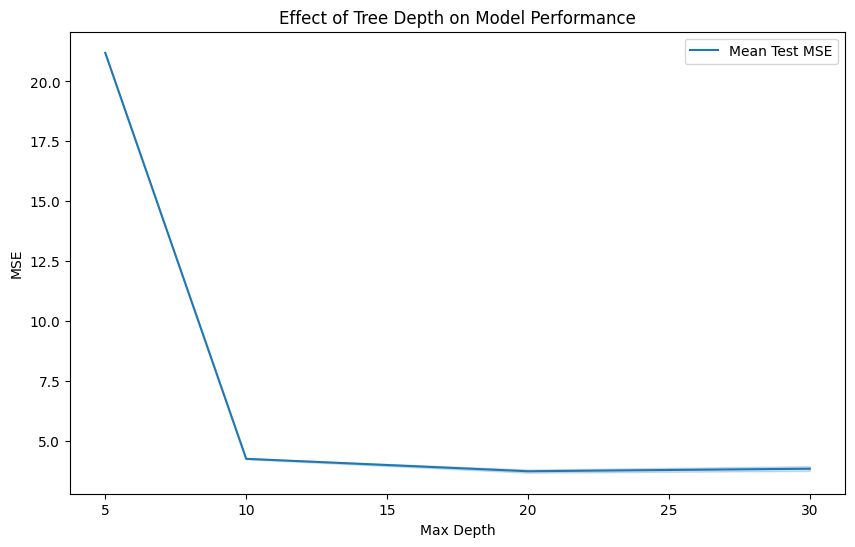

In [11]:
# Comparing multiple hyperparameter settings
results = pd.DataFrame(grid_search.cv_results_)


# Plotting RMSE vs hyperparameters
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['param_max_depth'], y=-results['mean_test_score'], label='Mean Test MSE')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Effect of Tree Depth on Model Performance')
plt.legend()
plt.show()

In [12]:
# Update the hyperparameter grid to include smaller depths, and larger sample splits/leaves
param_grid = {
    'max_depth': [10, 20, 30],  
    'min_samples_split': [2, 5, 7],  # Increase the minimum samples required to split a node to prevent the tree from growing too deep
    'min_samples_leaf': [5, 10, 15],  # Increase the minimum samples required in a leaf node to make the tree more generalized
    'ccp_alpha': [0.001, 0.01, 0.1]  # Increase pruning to avoid overly complex trees
}

# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()

# Perform Grid Search with cross-validation, including pruning
grid_search = GridSearchCV(dtr, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model after hyperparameter tuning
best_tree = grid_search.best_estimator_

# Print best parameters
print(f"Best hyperparameters for Decision Tree: {grid_search.best_params_}")

Best hyperparameters for Decision Tree: {'ccp_alpha': 0.001, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [13]:
# Predicting on training and test sets
y_train_pred_tree = best_tree.predict(X_train_scaled)
y_test_pred_tree = best_tree.predict(X_test_scaled)
y_val_pred_tree = best_tree.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print test metrics
print("\nDecision Tree Regression Model - Test Metrics:")
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:")  # Add this block for validation metrics
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 2.5137, RMSE: 1.5855, R²: 0.9997

Decision Tree Regression Model - Test Metrics:
MSE: 3.9068, RMSE: 1.9766, R²: 0.9996

Decision Tree Regression Model - Validation Metrics:
MSE: 3.4656, RMSE: 1.8616, R²: 0.9996


In [14]:
# Comparing multiple hyperparameter settings
results = pd.DataFrame(grid_search.cv_results_)
results.replace([np.inf, -np.inf], np.nan, inplace=True)

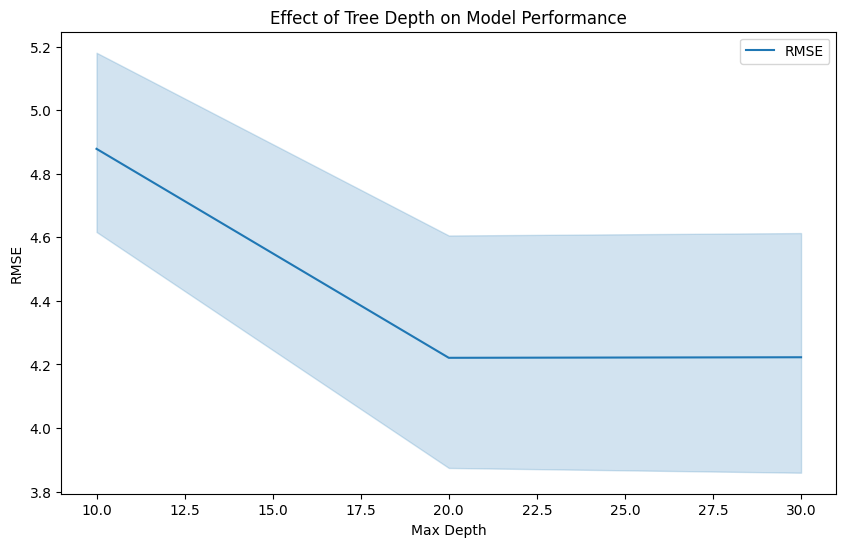

In [15]:
# Plotting RMSE vs hyperparameters
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['param_max_depth'], y=-results['mean_test_score'], label='RMSE')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Effect of Tree Depth on Model Performance')
plt.legend()
plt.show()

In [16]:
# Get the feature importances from the best tree
feature_importances = best_tree.feature_importances_

# Create a DataFrame to display feature importance
features_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(features_df)

                        Feature  Importance
46                  eta_minutes    0.849428
79                    name_Taxi    0.141508
72               name_Black_SUV    0.002291
75            name_Lux_Black_XL    0.002279
3                      distance    0.001561
..                          ...         ...
21  apparentTemperatureHighTime    0.000000
14                 windGustTime    0.000000
10            precipProbability    0.000000
2                         month    0.000000
84                cab_type_Uber    0.000000

[85 rows x 2 columns]
